In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
sample_path = 'sample_submission_V2.csv' 
train_path = 'train_V2.csv'
test_path = 'test_V2.csv'
sample = pd.read_csv(sample_path)
train= pd.read_csv(train_path)
test=pd.read_csv(test_path)

In [5]:
df_o= pd.read_csv(train_path)
df_o= df_o.dropna()


In [6]:
df=df_o.copy()

In [7]:
#캐쥬얼 모드 분석-> 이상치 생각보다 적음
# 테스트 자료에 캐쥬얼모드가 포함되어 있으면 포함하는게 좋을듯
# 캐쥬얼모드를 제외한 모델을 전체 데이터에 예측 0.10801
# 캐쥬얼모드와 노말모드 제거 -> 0.0968
# 캐쥬얼모드와 노말모드 포함 ->0.0978
# 캐쥬얼 모드만 ->0.11
# casual = train[(train['matchType'] =='flaretpp')|
#    (train['matchType'] =='flarefpp')|
#    (train['matchType'] =='crashfpp')|
#    (train['matchType'] =='crashtpp')]
# casual

In [8]:
# #캐쥬얼 모드 히트맵으로 상관성 분석
# plt.figure(figsize=(12,12))
# sns.heatmap(casual.corr(),annot=True)

In [9]:
# # 캐쥬얼모드 각 컬럼별 winPlacePerc와의 상관성 시각화
# col_name=['assists', 'boosts', 'damageDealt', 'DBNOs',
#        'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
#        'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
#        'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
#        'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
#        'weaponsAcquired', 'winPoints']
# for i in col_name:
#     sns.jointplot(x='winPlacePerc',y=i,data=casual,height=5, ratio=3)


In [10]:
#casual.describe()
#casual.corr()

In [11]:
#데이터 타입 최적화
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df = reduce_mem_usage(df)
test = reduce_mem_usage(test)

In [12]:
# 캐주얼, 노말 모드 drop
# df= df[~(df['matchType'] =='flaretpp')&
#    ~(df['matchType'] =='flarefpp')&
#    ~(df['matchType'] =='crashfpp')&
#    ~(df['matchType'] =='crashtpp')&
#    ~(df['matchType'] =='normal-squad-fpp')&
#    ~(df['matchType'] =='normal-solo-fpp')&
#    ~(df['matchType'] =='normal-duo-fpp')&
#    ~(df['matchType'] =='normal-duo')&
#    ~(df['matchType'] =='normal-squad')&
#    ~(df['matchType'] =='normal-solo')]

In [49]:
# matchid 60명 이하인 데이터 drop
# matchId_drop = df['matchId'].value_counts().loc[df['matchId'].value_counts()>60].index
# df = df.loc[df['matchId'].isin(matchId_drop)]

In [ ]:
# df = df.drop(columns=['Id',
#                  'killPoints',
#                  'matchDuration',
#                  'maxPlace',
#                  'teamKills',
#                  'roadKills',
#                  'vehicleDestroys',
#                 ])

EDA

In [ ]:
#damageDealt는 데미지를 많이 준것으로 보아 전투를 많이하고 생존을 오래했을 확률이 오를것이라고 판단
#DBNOs 또한 상관성이 높은 것으로 보임
#killplace 등수를 역순으로 나열한 것으로 상관성이 높음
#matchDuration는 게임의 시간을 나타냄으로 게임내의 모든 플레이어가 같은 패턴을 가지므로 생존과의 연관성이 부족
#maxPlace는 게임내의 꼴등을 나타내는 지표로써 직접적인 연관성은 부족하지만 학습에 필요한 데이터가 될수도 있다고 판단
#numGroups는 maxPlace와 비슷한 맥락으로 판단이 됨
#roadKills는 대부분 0에 가까운 수치를 가지며 생존과는 크게 연관성이 있다고 판단되지않음
#vehicleDestroys는 0에 많은 분포를 가지고 있지만 그래프상 연관성이 있다고 판단이 되고 게임의 특성상 
#후반부전투와 파괴하는 플레이어의 실력이 어느정도 생존 등수에 좋은 영향을 끼친다고 추측함
col_name=[ 'damageDealt', 'DBNOs','killPlace', 'matchDuration', 'matchType', 'maxPlace','numGroups',  'roadKills',
      'vehicleDestroys']
for i in col_name:
    sns.jointplot(x='winPlacePerc',y=i,data=df,height=5, ratio=3)

In [ ]:
# 상관성이 낮음 게임에서 영향력이 좋은 지표
rank_col=['killPoints','rankPoints', 'winPoints' ]

for i in rank_col:
    sns.jointplot(x='winPlacePerc',y=i,data=df,height=5, ratio=3)

In [ ]:
#어시스트는 많이 할수록 등수가 올라갈 가능성이 높음
#팀원을 부활시키는 것은 등수에 미미한 영향을 끼치는 것으로 보임
#팀킬은 대부분의 유저가 하지않은 행동이고 팀킬의 수가 적을수록 등수가 높아질수있음을 보이지만 미미함
team_col=['assists','revives',  'teamKills']

for i in team_col:
    sns.jointplot(x='winPlacePerc',y=i,data=df,height=5, ratio=3)

In [ ]:
#이동거리에 따라 생존에 영향을 미치는 것으로 판단
distance_col=[ 'swimDistance', 'walkDistance',]

for i in distance_col:
    sns.jointplot(x='winPlacePerc',y=i,data=df,height=5, ratio=3)

In [ ]:
#생존과 관련된 아이템으로 생존에 영향을 많이 끼침,
item_col=['boosts','heals','weaponsAcquired',]

for i in item_col:
    sns.jointplot(x='winPlacePerc',y=i,data=df,height=5, ratio=3)

In [ ]:
#kill 관련 컬럼은 대부분 등수예측에 영향을 줌
#killStreaks 초반싸움속에 많이 발생하여 등수예측에 영향이 적을 것으로 판단
kill_col=['kills','killStreaks', 'longestKill','headshotKills',]

for i in kill_col:
    sns.jointplot(x='winPlacePerc',y=i,data=df,height=5, ratio=3)


In [ ]:
# #Distance
# plt.subplot(1,3,1)
# sns.boxplot(data=train['rideDistance'])
# plt.title('rideDistance')
# plt.subplot(1,3,2)
# sns.boxplot(data=train['walkDistance'])
# plt.title('walkDistance')
# plt.subplot(1,3,3)
# sns.boxplot(data=train['swimDistance'])
# plt.title('swimDistance')
# plt.subplot(1,3,1)
# plt.hist(train['rideDistance'])
# plt.title('rideDistance')
# plt.subplot(1,3,2)
# plt.hist(train['walkDistance'])
# plt.title('walkDistance')
# plt.subplot(1,3,3)
# plt.hist(train['swimDistance'])
# plt.title('swimDistance')
# #rideDistance-15000,walkDistance-15000, swimDistance-2500

In [142]:
train[train['groupId']=='fffff7edfc4050']

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2960097,9a0e79cb645bc7,fffff7edfc4050,e9ec61d20d9ca3,0,2,529.300,2,3,2,6,0,4,2,153.600,1985,duo-fpp,47,45,1521,0,4663.0,0,0.0,0,0,1975.0,6,0,0.9783
3900584,91279588807af3,fffff7edfc4050,e9ec61d20d9ca3,0,4,4.838,0,0,1,22,0,1,1,6.357,1985,duo-fpp,47,45,1521,1,5914.0,0,0.0,0,0,2592.0,6,0,0.9783


전처리

In [130]:
df_col= [ 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc']

In [131]:
# groupId는 모두 winplacePerc가 같다는 정보를 토대로 groupId를 묶고 모든 값들을 평균냄-> 
#일찍 죽어서 아웃된 사람들이 끼치는 영향을 최소하기위해 데이터를 최소화
df_t= df.groupby(['groupId'])[df_col].agg('mean').reset_index()
df_t

,groupId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,00000c08b5be36,0.000000,0.333333,247.125,1.666667,0.333333,0.333333,50.333333,0.0,0.666667,0.666667,9.046875,1429.0,26.0,26.0,1457.333333,0.000000,0.00,0.0,0.000000,0.0,0.0,271.5000,2.333333,0.0,0.199951
1,00000d1cbbc340,0.000000,0.000000,173.750,0.000000,0.000000,0.000000,40.000000,0.0,1.000000,1.000000,1.963867,1196.0,27.0,24.0,1551.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,135.7500,3.000000,0.0,0.115417
2,000025a09dd1d7,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,72.000000,0.0,0.000000,0.000000,0.000000,2021.0,91.0,89.0,1584.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,110.8125,2.000000,0.0,0.199951
3,000038ec4dff53,0.666667,2.333333,263.500,1.666667,0.333333,3.000000,13.000000,0.0,2.000000,1.000000,53.500000,1470.0,27.0,27.0,1516.000000,0.666667,0.00,0.0,74.937500,0.0,0.0,2084.0000,5.666667,0.0,0.961426
4,00003a54230763,0.500000,0.000000,50.000,0.500000,0.500000,0.000000,54.500000,1013.0,0.500000,0.500000,1.585938,2190.0,44.0,42.0,-1.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,92.6250,2.500000,1501.0,0.139526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026739,ffffedb6ecff6a,0.000000,0.000000,50.000,0.500000,0.000000,0.000000,87.500000,0.0,0.000000,0.000000,0.000000,1896.0,28.0,26.0,1364.500000,0.000000,0.00,0.0,0.000000,0.0,0.0,156.1250,1.500000,0.0,0.036987
2026740,fffff305a0133d,0.500000,2.500000,208.375,1.000000,1.000000,2.500000,18.000000,0.0,2.000000,1.500000,17.437500,1340.0,48.0,47.0,1515.500000,0.000000,82.25,0.0,1.207031,0.0,0.0,2562.0000,4.000000,0.0,0.851074
2026741,fffff32bc7eab9,0.000000,0.000000,300.000,0.000000,1.000000,0.000000,10.000000,1166.0,3.000000,2.000000,8.218750,1894.0,93.0,88.0,-1.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,114.6875,1.000000,1443.0,0.250000
2026742,fffff7edfc4050,0.000000,3.000000,267.250,1.000000,1.500000,1.500000,14.000000,0.0,2.500000,1.500000,80.000000,1985.0,47.0,45.0,1521.000000,0.500000,5288.00,0.0,0.000000,0.0,0.0,2284.0000,6.000000,0.0,0.978516


In [132]:
df_t = df_t.drop(columns=['killPlace','groupId','kills'])
#df_test = test.drop(columns=['groupId','matchId','killPlace','Id'])

In [133]:
# IQR을 활용한 이상치 제거
check_column=['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
        'killStreaks', 'longestKill', 'maxPlace',
       'numGroups', 'revives', 'rideDistance', 'roadKills', 'swimDistance',
       'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired']
df_t_IQR = df_t.copy()
for i in check_column:
    quantile_25 = np.percentile(df_t[i].values, 25)
    quantile_75 = np.percentile(df_t[i].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*1.5
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    outlier_idx = df_t_IQR[i][ (df_t_IQR[i] < lowest) | (df_t_IQR[i] > highest) ].index
    df_t_IQR = df_t.drop(outlier_idx, axis=0)
    print(len(outlier_idx))
# 원핫인코딩
# df_inco = pd.get_dummies(df_t_IQR['matchType'])
# df_t_IQR = pd.concat([df_t_IQR,df_inco],axis=1)
# df_t_IQR = df_t_IQR.drop(columns='matchType')
# 라벨인코딩
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df_t_IQR['matchType']= le.fit_transform(df_t_IQR['matchType'])
# df_t_IQR['matchType']
#큰 차이가 발생하지 않음-> 원핫인코딩과 라벨인코딩이 트리기반 모델에 성능향싱이 되지않음을 알 수 있음
# df_t_IQR['matchType'] = df_t_IQR['matchType'].astype('category')


230852
39698
91642
40877
236367
96091
4394
214218
0
0
441286
279691
5419
191436
75656
25874
11442
19693


In [15]:
# x_train=df_t_IQR.drop(columns='winPlacePerc')
# y_train=df_t_IQR[['winPlacePerc']]
# x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
# x_train.shape,x_test.shape,y_train.shape,y_test.shape

In [16]:
# distance 이상치 제거
# 성능향상 
# out=df_t['rideDistance']>20000.0
# ride_drop=df_t[out].index
# df_t=df_t.drop(ride_drop)
# out=df_t['walkDistance']>15000.0
# distance_drop=df_t[out].index
# df_t=df_t.drop(distance_drop)
# out=df_t['swimDistance']>2500.0
# distance_drop=df_t[out].index
# df_t=df_t.drop(distance_drop)

In [17]:
#합쳐보자
#df_t['totalDistance']=df_t['rideDistance']+df_t['walkDistance']+df_t['swimDistance']
#df_t=df_t.drop(columns=['rideDistance','walkDistance','swimDistance'])


In [18]:
#matchType을 one-hot encoding
# df_inco = pd.get_dummies(df_t['matchType'])
# df_t = pd.concat([df_t,df_inco],axis=1)
# df_t = df_t.drop(columns='matchType')


모델링 학습

In [134]:
x=df_t_IQR.drop(columns='winPlacePerc')
y=df_t_IQR[['winPlacePerc']]


In [135]:
df_t_IQR

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPoints,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0.000000,0.333333,247.125,1.666667,0.333333,0.333333,0.0,0.666667,9.046875,1429.0,26.0,26.0,1457.333333,0.000000,0.00,0.0,0.000000,0.0,0.0,271.5000,2.333333,0.0,0.199951
1,0.000000,0.000000,173.750,0.000000,0.000000,0.000000,0.0,1.000000,1.963867,1196.0,27.0,24.0,1551.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,135.7500,3.000000,0.0,0.115417
2,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2021.0,91.0,89.0,1584.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,110.8125,2.000000,0.0,0.199951
3,0.666667,2.333333,263.500,1.666667,0.333333,3.000000,0.0,1.000000,53.500000,1470.0,27.0,27.0,1516.000000,0.666667,0.00,0.0,74.937500,0.0,0.0,2084.0000,5.666667,0.0,0.961426
4,0.500000,0.000000,50.000,0.500000,0.500000,0.000000,1013.0,0.500000,1.585938,2190.0,44.0,42.0,-1.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,92.6250,2.500000,1501.0,0.139526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026739,0.000000,0.000000,50.000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,1896.0,28.0,26.0,1364.500000,0.000000,0.00,0.0,0.000000,0.0,0.0,156.1250,1.500000,0.0,0.036987
2026740,0.500000,2.500000,208.375,1.000000,1.000000,2.500000,0.0,1.500000,17.437500,1340.0,48.0,47.0,1515.500000,0.000000,82.25,0.0,1.207031,0.0,0.0,2562.0000,4.000000,0.0,0.851074
2026741,0.000000,0.000000,300.000,0.000000,1.000000,0.000000,1166.0,2.000000,8.218750,1894.0,93.0,88.0,-1.000000,0.000000,0.00,0.0,0.000000,0.0,0.0,114.6875,1.000000,1443.0,0.250000
2026742,0.000000,3.000000,267.250,1.000000,1.500000,1.500000,0.0,1.500000,80.000000,1985.0,47.0,45.0,1521.000000,0.500000,5288.00,0.0,0.000000,0.0,0.0,2284.0000,6.000000,0.0,0.978516


In [143]:
#Standardscaler
#minmaxscaler
#mm_scaler=MinMaxScaler()
scaler = StandardScaler()
# x=x.drop(columns='matchType')
x=scaler.fit_transform(x)
# x=np.append(x,df_t_IQR[['matchType']],axis=0)

#x=mm_scaler.fit_transform(x)
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=0)
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((1605640, 22), (401411, 22), (1605640, 1), (401411, 1))

In [137]:
# lightgbm 활용-> 학습용
import lightgbm as lgb
d_train = lgb.Dataset(x_train, label=y_train)
d_val = lgb.Dataset(x_val,label=y_val)
params = {"objective" : "regression", "metric" : "mae", 'n_estimators':1000, 'early_stopping_rounds':200,
              "num_leaves" : 31, "learning_rate" : 0.05, "bagging_fraction" : 0.7,
               "bagging_seed" : 0, "num_threads" : 4,"colsample_bytree" : 0.7
             }
# params = {}
# params['metric'] = 'mae'
# params['boosting_type'] = 'gbdt'
# params['objective'] = 'regression'
# params['max_depth'] = 100
clf = lgb.train(params, d_train, valid_sets=[d_train, d_val],early_stopping_rounds=200, verbose_eval=1000)
# pred = clf.predict(x_test, num_iteration=clf.best_iteration)
#mae=mean_absolute_error(y_test,pred)
print(clf)
#print(format(mae,'.10f'))



/Users/packchansaem/miniforge3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/packchansaem/miniforge3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/packchansaem/miniforge3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3526
[LightGBM] [Info] Number of data points in the train set: 1605640, number of used features: 22
[LightGBM] [Info] Start training from score 0.497095
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 0.0689535	valid_1's l1: 0.0694322
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 0.0689535	valid_1's l1: 0.0694322


In [92]:
#모델 테스트
x_test=test.copy()
x_test
x_test = x_test.dropna()
le = LabelEncoder()
x_test['matchType']= le.fit_transform(x_test['matchType'])
x_test['matchType']
x_test=x_test.drop(columns=['groupId','matchId','killPlace','Id'])


In [145]:
# xgboost 활용
import xgboost
xgb_model = xgboost.XGBRegressor(
    eval_metric=mean_absolute_error
    ,random_state=42)

xgb_model.fit(x_train,y_train)

pred = xgb_model.predict(x_val)
mae = mean_absolute_error(y_val, pred)
print(format(mae,'.5f'))

0.07013


In [48]:
# #원본
# #비교 위해 컬럼만 제거한 데이터 
# train = train.dropna()
# le = LabelEncoder()
# # 라벨 인코딩
# train['matchType']= le.fit_transform(train['matchType'])
# train['matchType']
# # 원핫인코딩
# # df_inco = pd.get_dummies(train['matchType'])
# # train = pd.concat([train,df_inco],axis=1)
# # train = train.drop(columns='matchType')
# # train['matchType'] = train['matchType'].astype('category')
# x=train.drop(columns=['winPlacePerc','groupId','matchId','killPlace','Id'])
# y=train[['winPlacePerc']]
# #스케일링
# scaler = StandardScaler()
# x=scaler.fit_transform(x)
# #테스트,트레인 데이터 분할
# # x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
# # x_train.shape,x_test.shape,y_train.shape,y_test.shape
# #학습한 모델로 원본 데이터 예측
# pred = clf.predict(x)
# mae=mean_absolute_error(y,pred)
# print(format(mae,'.5f'))


0.08973


In [138]:
cv_results = lgb.cv(params, d_train, num_boost_round=200, nfold=5, 
                    verbose_eval=20, early_stopping_rounds=40,stratified=False)
print('Best CV score:', cv_results['l1-mean'][-1])

/Users/packchansaem/miniforge3/lib/python3.9/site-packages/lightgbm/engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/packchansaem/miniforge3/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3526
[LightGBM] [Info] Number of data points in the train set: 1284512, number of used features: 22
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3526
[LightGBM] [Info] Number of data points in the train set: 1284512, number of used features: 22
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3526
[LightGBM] [Info] Num

/Users/packchansaem/miniforge3/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Start training from score 0.497187
[20]	cv_agg's l1: 0.12847 + 7.37846e-05
[40]	cv_agg's l1: 0.0872546 + 3.16034e-05
[60]	cv_agg's l1: 0.0769089 + 5.69731e-05
[80]	cv_agg's l1: 0.073807 + 6.44436e-05
[100]	cv_agg's l1: 0.0725537 + 6.62527e-05
[120]	cv_agg's l1: 0.0718917 + 6.56927e-05
[140]	cv_agg's l1: 0.0714762 + 7.16438e-05
[160]	cv_agg's l1: 0.0711634 + 6.68501e-05
[180]	cv_agg's l1: 0.0709309 + 6.9018e-05
[200]	cv_agg's l1: 0.0707452 + 6.91357e-05
[220]	cv_agg's l1: 0.0705983 + 6.84536e-05
[240]	cv_agg's l1: 0.0704764 + 6.61477e-05
[260]	cv_agg's l1: 0.0703698 + 6.79462e-05
[280]	cv_agg's l1: 0.0702833 + 6.67658e-05
[300]	cv_agg's l1: 0.0702062 + 6.59294e-05
[320]	cv_agg's l1: 0.0701455 + 6.64455e-05
[340]	cv_agg's l1: 0.070092 + 6.42383e-05
[360]	cv_agg's l1: 0.0700409 + 6.72954e-05
[380]	cv_agg's l1: 0.069996 + 6.64528e-05
[400]	cv_agg's l1: 0.069954 + 6.79008e-05
[420]	cv_agg's l1: 0.069918 + 6.89071e-05
[440]	cv_agg's l1: 0.0698877 + 6.89922e-05
[460]	cv_agg'

<Figure size 1080x1440 with 0 Axes>

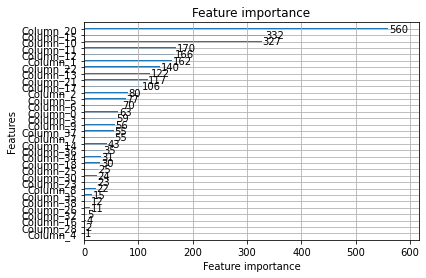

In [97]:
# plt.figure(figsize=(15,20))
# lgb.plot_importance(clf)
# plt.show()

In [ ]:
#iqr로 이상치를 제거한 lightgbm
# x=df_t_IQR.drop(columns='winPlacePerc')
# y=df_t_IQR[['winPlacePerc']]

# x=normalize(x)


# scaler = StandardScaler()
# x=scaler.fit_transform(x)
# x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
# x_train.shape,x_test.shape,y_train.shape,y_test.shape

# d_train = lgb.Dataset(x_train, label=y_train)
# params = {}
# params['metric'] = 'mae'
# params['boosting_type'] = 'gbdt'
# params['objective'] = 'regression'
# clf = lgb.train(params, d_train, 100)
# pred = clf.predict(x_test)
# mae=mean_absolute_error(y_test,pred)
# print(format(mae,'.5f'))

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
# dicision tree
# from sklearn.tree import DecisionTreeRegressor
# d_tree =DecisionTreeRegressor(criterion='absolute_error',random_state=42,max_depth=10) 
# d_tree.fit(x_train,y_train)
# pred = d_tree.predict(x_test)
# mae = mean_absolute_error(y_test,pred)
# print(format(mae,'.5f'))

In [ ]:
# # k-fold 교차 검증
# from sklearn.model_selection import StratifiedKFold
# import lightgbm as lgb
# from sklearn.model_selection import KFold
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# sfk = StratifiedKFold(n_splits=5)
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)
# y_pred = np.zeros(len(X_test))
# for train_index, test_index in sfk.split(x,y):
#     X_train = x.iloc[train_index, :]
#     y_train = y[train_index]
#     X_val = x.iloc[test_index, :]
#     y_val = y[test_index]
#     lgbm = lgb.LGBMRegressor(n_estimators = 100, learning_rate= 0.1,objective = 'mae')
#     lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'mae', early_stopping_rounds= 50,verbose = 100)
#     y_pred += lgbm.predict(X_test) / 5
# print(y_pred)
# 실패 모르겟음